# Supernova spectrum matching and classification notebook

### Import packages needed and define a stats function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions import ProcessSpectra, BinSpec, split, get_classification, dered, get_spec_matches, target_wavelength_range
from glob import glob
from joblib import dump, load
import os
%matplotlib inline

In [23]:
def get_z_stats(get_sn = False, get_type = False, plot = True ):
    '''
    Returns the z stats for either a particular supernova as defined by get_sn,
    or a particular type as defined by get_type.
    Output is one tuple and two arrays; 
    
    [0] = (median, mean, std)
    [1] = redshift array
    [2] = weights array for plt.hist weights argument
    '''
    
    
    # set the empty lists
    stats = []
    w = []
    
    # set parameters for a supernova or a type
    if get_sn:
        sn_matches = [get_sn]
        list_to_use = sne
        
    if get_type:
        sn_matches = set(sne)
        list_to_use = types
     
    # iterate through the lists to get the redshifts that match the conditions
    for this_sn in sn_matches:        
        for idx ,obj in enumerate(list_to_use):
            
            if (obj == this_sn) or (obj == get_type):
                stats.append(zs[idx])
                w. append(sorted_scores[idx])
                
    # normalise the scores to the score in the list. This is for 'weights' in plt.hist            
    w =  ( w / max(sorted_scores) ) ** 4 
    
    # cast as numpy array
    stats = np.array(stats)
    w = np.array(w)
    
    if plot:
        plt.hist(stats, weights = w, color = 'k', facecolor = 'tab:green', zorder = 0, rwidth= 0.9, density = True)
        plt.axvline(x = np.average(stats, weights = w), linestyle = 'dashed' , color = 'k')
        plt.axvline(x = np.average(stats, weights = w) + np.std(stats), linestyle = 'dotted', color = 'k' )
        plt.axvline(x = np.average(stats, weights = w) - np.std(stats), linestyle = 'dotted', color = 'k' )
        plt.xlabel('Redshift')
        plt.ylabel('weighted counts')
    
    return (np.median(stats), np.average(stats, weights = w), np.std(stats) ), stats, w

def plot(spectrum, E = False, i = 15, scaling = 6000):
    print(f'Top {i} matches to {os.path.basename(spectrum)}')
    
    x , y = np.loadtxt(spectrum, usecols = (0,1) ,unpack= True )

    if E:
        y = dered(x, y, 3.1, E)

    #ref_lam = 6000

    #scale = y[np.argmin(abs(x - ref_lam))]
    #y = y / scale
    
    if scaling == 'normed':
        m=1/(max(y)-min(y))
        con=-m*min(y)    
        y = np.array([m*d+con for d in y])
    else:  
        scale = y[np.argmin(abs(x - scaling))]
        y = y / scale    

    plt.figure(figsize = (15,19))
    used =[]
    n = 0
    for i, spec in enumerate(all_specs):
        #if i <15:
        if (sne[i] not in used) and (n < 15):
            used.append(sne[i])
        
            plt.subplot(5,3, n + 1)
            plt.plot(x, y)
    
            x_, y_ = np.loadtxt(ref_location + spec, unpack = True)
    
            x_ = x_ * (1 + zs[i])
    
            #scale = y_[np.argmin(abs(x_ - ref_lam))]
            #y_ = y_ / scale
            
            if scale == 'normed':
                m = 1 / (max(y_) - min(y_))
                con = -m * min(y_)    
                y_ = np.array([m*d+con for d in y_])
            else:  
                scale = y_[np.argmin(abs(x_ - scaling))]
                y_ = y_ / scale
        
            fit_score = sorted_scores[i] / max(sorted_scores)
            plt.plot(x_, y_, label = f'{types[i]} {sne[i]} (t = {epochs[i]})\n@ $z=$ {zs[i]}, score = {fit_score:.2f}', alpha = 0.8)

            plt.legend(frameon = False)
            plt.minorticks_on()
            # this messes up if i changes
            if n in  [0, 3, 6, 9, 12]:
                plt.ylabel('Scaled flux')
            if n in [14, 13 ,12]:
                plt.xlabel('Observed wavelength [$\mathrm{\AA}$]')
        
            n+=1
        #else:
        #    break

Load the model and the list of classifications for the spectra in the model

In [3]:
# Load the model
model_location = './models/2021-03-04_KNNClassification_model.k=1000.joblib'
clf = load(model_location) 

# load the class list for this model
classlist = np.loadtxt('./PCA_ready/classlist.2021-03-04.txt',dtype='str')
classlist.sort()

# set the list of the spectra for the templates
ref_sne = glob('./spectra/*')
ref_location = './spectra/'

## --User defined--
### Set the input spectrum

In [4]:
# For a single spectrum
specname = 'tns_2021bsr_2021-02-14_NOT_ALFOSC_YSE.txt'

spectrum = f'./for_classification/{specname}'

# set extinction and the redshift, if known
E = False
redshift = False
pad = True

In [38]:
# For multiple spectra in a folder
folder = '/Users/sprentice/Documents/SN_classifier/for_classification/pessto/'
#folder = '/Users/sprentice/Documents/classifications/LT-Quick-Bulk/OutputSpectra/'

# print the file names in order
spectra = glob(folder +'*')
for idx, i in enumerate(spectra):
    print(idx, os.path.basename(i ) )

# choose the object and set extinction and the redshift, if known
index = 2
E = False
redshift = False
pad = True

# set spectum name ad if necessary pad and deredden
spectrum = spectra[index]

# print the chose spectrum for classification
print(f'\nclassifying {os.path.basename(spectrum) }')

0 2021fmu_20210323.w_snid.output
1 2021fak_20210321.w_snid.output
2 tSN2018beh_20180522_Gr11_Free_slit1.0_1_f.asci
3 2021fak_20210321.w.txt
4 2020flc.c.txt
5 snid.param
6 2021fmu_20210323.w.txt
7 20180516_LCO.txt
8 SN2021gfo_2021-03-21_02-11-22.811_ESO-NTT_EFOSC2-NTT_ePESSTOp.asci
9 2021ckb_20210323.w.txt
10 2020flc.c_snid.output

classifying tSN2018beh_20180522_Gr11_Free_slit1.0_1_f.asci


# Get the best match and the scores for all the matches

### To get the classification matches, call the _get_classification_ function with the following arguments

best_match, indices, scores = get_classification( spectrum location, model, E, pad)

-- _spectrum location_ is a string of the spectrum location.

-- _model_ is the model imported earlier, usually just called clf.

-- _E_ is either a float or False. If omitted, _E_ = False.

-- _pad_ is a boolean set to False by default and pads out spectra that are shorter than _target_wavelength_range_

In [39]:
best_match, indices, scores = get_classification(spectrum, clf, E = E, pad = pad)
best_match_properties = split(best_match)[0]
best_match_properties
print(f'The best match is {best_match_properties[0]} {best_match_properties[1]} (t = {best_match_properties[3]} d) at z = {best_match_properties[2]}')

The best match is Ia-SupCh SN2009dc (t = 11.4 d) at z = 0.044


### Sort all the matches by score then return them in a list

In [40]:
sorted_scores, sorted_idxs = zip(*list(sorted(zip(scores,indices), reverse=True)))

a  = get_spec_matches(idxs = sorted_idxs, z = redshift, classlist = classlist )
types, sne, zs, epochs, all_specs = zip(*a)

# list the top 15 matches
a[:15]

[('Ia-SupCh', 'SN2009dc', 0.044, 11.4, 'Ia-SupCh_SN2009dc_11.40_.txt'),
 ('Ia-SupCh', 'SN2009dc', 0.042, 11.4, 'Ia-SupCh_SN2009dc_11.40_.txt'),
 ('Ic-7', 'SN2007gr', 0.06, -8.42, 'Ic-7_SN2007gr_-8.42_.txt'),
 ('Ic-7', 'SN2007gr', 0.058, -8.42, 'Ic-7_SN2007gr_-8.42_.txt'),
 ('Ia-SupCh', 'SN2009dc', 0.046, 11.4, 'Ia-SupCh_SN2009dc_11.40_.txt'),
 ('Ic-7', 'SN2007gr', 0.062, -8.42, 'Ic-7_SN2007gr_-8.42_.txt'),
 ('Ia', 'SN2013dy', 0.058, 10.27, 'Ia_SN2013dy_10.27_.txt'),
 ('Ia', 'SN2013dy', 0.056, 10.27, 'Ia_SN2013dy_10.27_.txt'),
 ('Ib', 'iPTF13bvn', 0.058, -15.98, 'Ib_iPTF13bvn_-15.98_.txt'),
 ('Ia-SupCh', 'SN2009dc', 0.048, 11.4, 'Ia-SupCh_SN2009dc_11.40_.txt'),
 ('Ic-7', 'SN2007gr', 0.056, -8.42, 'Ic-7_SN2007gr_-8.42_.txt'),
 ('Ia-SupCh', 'SN2009dc', 0.04, 11.4, 'Ia-SupCh_SN2009dc_11.40_.txt'),
 ('Ib', 'iPTF13bvn', 0.056, -15.98, 'Ib_iPTF13bvn_-15.98_.txt'),
 ('Ia', 'SN2013dy', 0.056, 10.89, 'Ia_SN2013dy_10.89_.txt'),
 ('Ia', 'SN2013dy', 0.06, 10.27, 'Ia_SN2013dy_10.27_.txt')]

## Plot the best 15 matches

Top 15 matches to tSN2018beh_20180522_Gr11_Free_slit1.0_1_f.asci


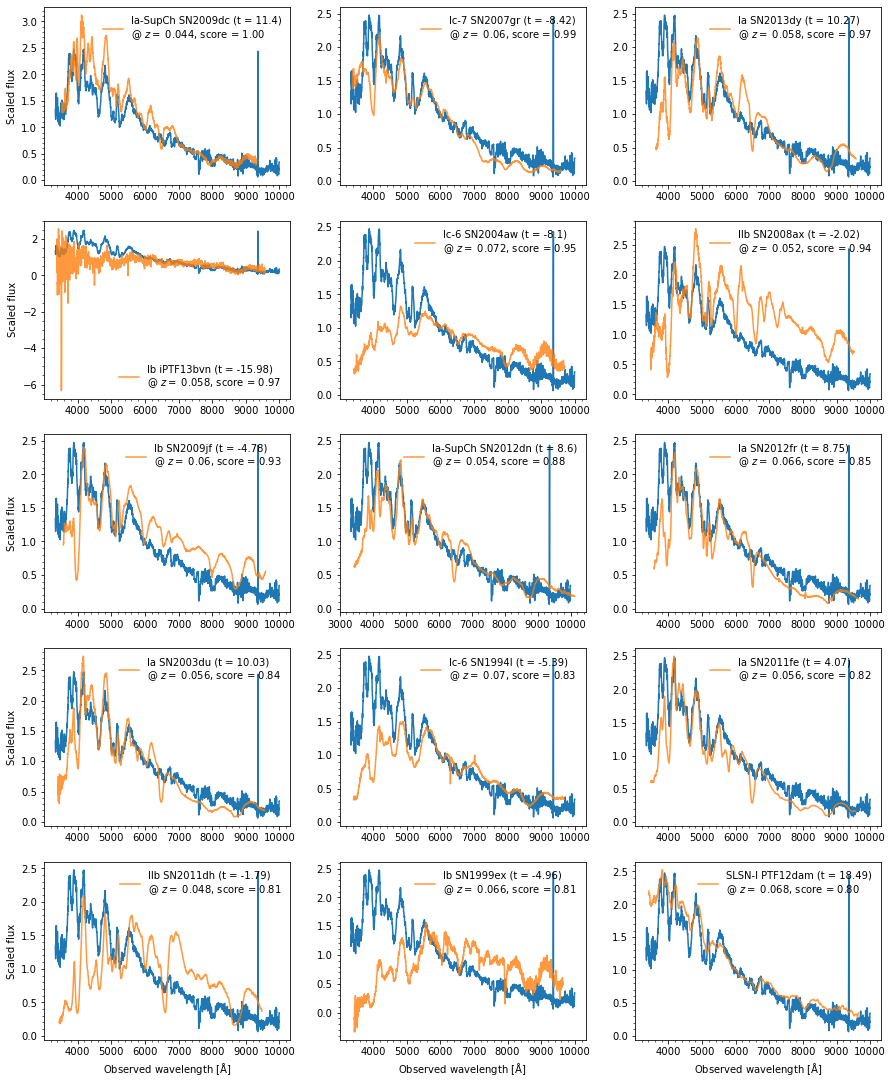

In [41]:
plot(spectrum, E = E, i = 15)

# spectrum match plot saves to the location of the spectrum
#plt.savefig(spectrum+'.pdf', bbox_inches='tight')

## Plot the redshift distributions
The first selects on SN type, be careful with this as although the bins components are weighted according to score
having a lot in one bin with a marginally lower score than the best fit gives a shifted average e.g., the sampling is not uniform!

### First from the best match object

SN2012dn z = 0.066 +-0.014 (std not weighted)


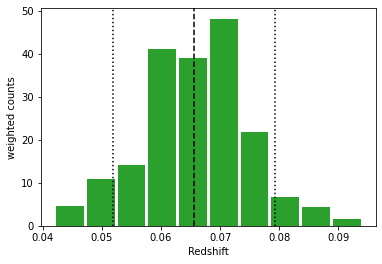

In [14]:
sn = sne[0]
z_stats = get_z_stats(get_sn = sn)
print(f'{sn} z = {z_stats[0][1]:.3f} +-{z_stats[0][2]:.3f} (std not weighted)'  )

### Next from a selected SN type

z = 0.064 +-0.011 (std not weighted)


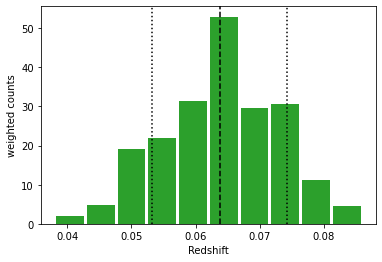

In [15]:
z_stats = get_z_stats(get_type = 'Ia')
print(f'z = {z_stats[0][1]:.3f} +-{z_stats[0][2]:.3f} (std not weighted)'  )

### Plot all the redshifts and phases

Text(0.5, 0, 'Redshift')

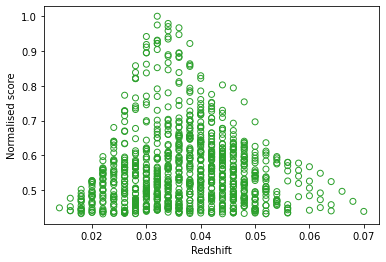

In [66]:
plt.scatter( zs, sorted_scores / max(sorted_scores), facecolor = 'none', color = 'tab:green')
plt.ylabel('Normalised score')
plt.xlabel('Redshift')

Text(0.5, 0, 'Epoch [days]')

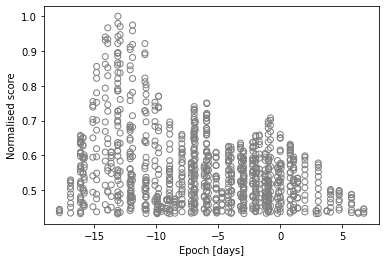

In [65]:
plt.scatter(epochs, sorted_scores / max(sorted_scores), facecolor = 'none', color = 'grey')
plt.ylabel('Normalised score')
plt.xlabel('Epoch [days]')

The same again but for an individual SN. Again the bin components are weighted according to score. This should be a little better than filtering on SN types

## Plot individual SN matches.
Simply define a part of the SN name to include in the search

In [39]:
# Quickly show the unique types and objects
print(set(types), set(sne))

{'Ib', 'Ia-SupCh', 'SLSN-I', 'Iax', 'IIb', 'Ic-BL', 'Ia-91bg', 'Ia-91T', 'Ia', 'Ic-7'} {'SN2008ax', 'SN2011fe', 'SN1999aa', 'SN2007gr', 'SN2005cf', 'SN2001V', 'PTF12dam', 'SN2012fr', 'SN2013dy', 'SN2003du', 'SN2009jf', 'SN2009dc', 'SN2006aj', 'iPTF13bvn', 'SN2011dh', 'SN2008ha', 'SN2012dn', 'SN2005ke'}


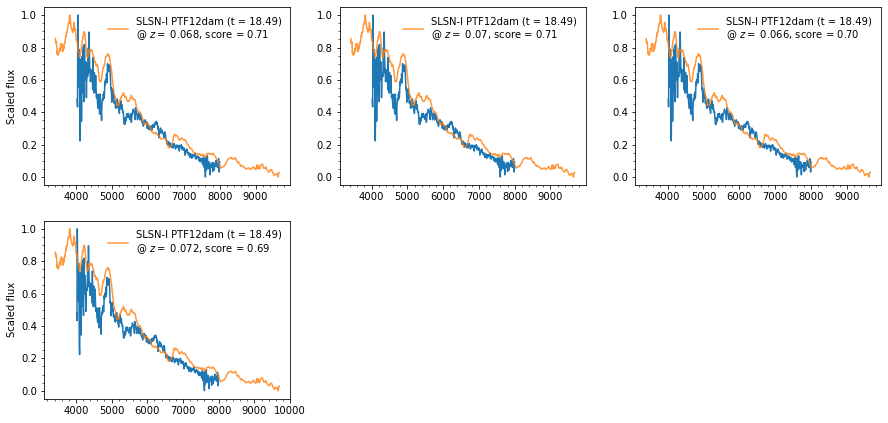

In [40]:
x , y = np.loadtxt(spectrum, usecols = (0,1) ,unpack= True )

if E:
    y = dered(x, y, 3.1, E)

m=1/(max(y)-min(y))
con=-m*min(y)    
y = np.array([m*d+con for d in y])

# need a rising index
n= 0

plt.figure(figsize = (15,19))
for i, spec in enumerate(all_specs):
    if '12dam' in spec and n < 15: 
        
        plt.subplot(5,3, n + 1)
        plt.plot(x, y)
    
        x_, y_ = np.loadtxt(ref_location + spec, unpack = True)
    
        x_ = x_ * (1 + zs[i])
    
        m = 1 / (max(y_) - min(y_))
        con = -m * min(y_)    
        y_ = np.array([m*d+con for d in y_])
    
        fit_score = sorted_scores[i] / max(sorted_scores)
        plt.plot(x_, y_, label = f'{types[i]} {sne[i]} (t = {epochs[i]})\n@ $z=$ {zs[i]}, score = {fit_score:.2f}', alpha = 0.8)

        plt.legend(frameon = False)
        plt.minorticks_on()
        
        # this messes up if the limit of n changes
        if n in  [0, 3, 6, 9, 12]:
            plt.ylabel('Scaled flux')
        if n in [14, 13 ,12]:
            plt.xlabel('Observed wavelength [$\mathrm{\AA}$]')
        #plt.show()
        n+=1
#plt.savefig(f'{spectrum}.pdf')

## If you need to quickly match some galaxy lines

(0.0, 2.0)

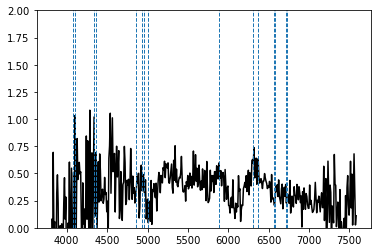

In [110]:
x, y = np.loadtxt(spectrum, unpack=True)
x = x / 1.054
plt.plot(x,y, color = 'k')

lines, *_ = np.loadtxt('./GalaxyLinesSDSS.txt', unpack = True, dtype = 'str', delimiter='\t')

for line in lines:
    plt.axvline(x = float(line), linestyle = 'dashed', lw = 1)

# plt.axvline(x = 6563)
# plt.axvline(x = 4861)
# plt.axvline(x = 4340)
#plt.xlim(4500, 5500)
plt.ylim(0,2)

In [70]:
lines

array(['4072.3', '4102.89', '4341.68', '4364.436', '4862.68', '4932.603',
       '4960.295', '5008.240', '6302.046', '5890', '6365.536', '6564.61',
       '6718.29', '6732.67'], dtype='<U8')